<a href="https://colab.research.google.com/github/m365i/hw-py-deep-learning/blob/main/flowers_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch is a deep learning framework with its Pythonic nature. Although there are many advanced applications, here I would like to demonstrate a solution for a relatively simple case. This is the multi-class classification problem based on Iris data set. It's the one of the best known practices.The model will be developed classifies the samples based on four features:<br>
* sepal length (cm)
* sepal width (cm)
* petal length (cm)
* petal width (cm)

Target labels (species) are:
* Iris-setosa
* Iris-versicolour
* Iris-virginica

We will develop a model by using PyTorch having input layer (features), hidden layers and output layer (classes) as usual in neural networks.

We will follow these steps:

* Preparing and loading dataset<br>
* Creating a model<br>
* Training and validating the model<br>
* Testing with unseen data


We start with importing necessary libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Dataset
We use dataset on Kaggle and you may use also this URL https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data for downloading .csv file.

In [ ]:
! wget -O iris.data.csv https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

--2022-04-23 17:38:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [application/x-httpd-php]
Saving to: ‘iris.data.csv’

iris.data.csv       100%[===================>]   4.44K  --.-KB/s    in 0s      

2022-04-23 17:38:52 (97.6 MB/s) - ‘iris.data.csv’ saved [4551/4551]



In [ ]:
dataset = pd.read_csv("iris.data.csv")

In [ ]:
dataset.columns = ["sepal length (cm)", 
                   "sepal width (cm)", 
                   "petal length (cm)", 
                   "petal width (cm)", 
                   "species"]

dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


We need to transform species data to numeric values.

In [ ]:
mappings = {
   "Iris-setosa": 0,
   "Iris-versicolor": 1,
   "Iris-virginica": 2
}
dataset["species"] = dataset["species"].apply(lambda x: mappings[x])

dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,4.9,3.0,1.4,0.2,0
1,4.7,3.2,1.3,0.2,0
2,4.6,3.1,1.5,0.2,0
3,5.0,3.6,1.4,0.2,0
4,5.4,3.9,1.7,0.4,0


It's always useful previewing the dataset which we are working on. It gives an idea about features and their patterns in entire dataset. For achieving this we can use visualization tools available with matplotlib library already imported.

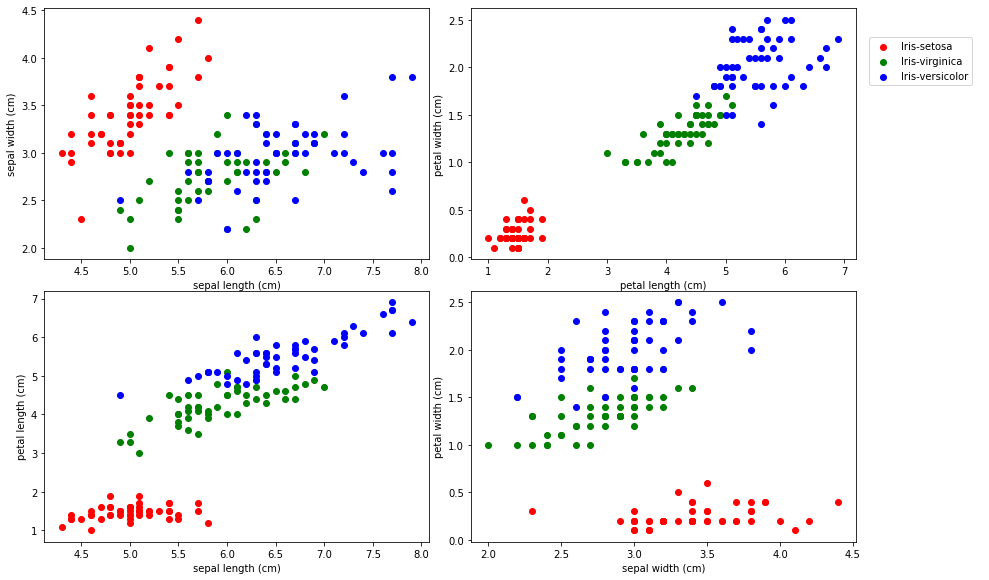

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ["r", "g", "b"]
labels = ["Iris-setosa","Iris-virginica","Iris-versicolor"]

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = dataset.columns[plots[i][0]]
        y = dataset.columns[plots[i][1]]
        ax.scatter(dataset[dataset["species"]==j][x], dataset[dataset["species"]==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

### Loading dataset

In [ ]:
X = dataset.drop("species",axis=1).values
y = dataset["species"].values

We split our dataset into training and test sets by ratio 80/20.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

In [ ]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

### Creating Model

* Fully Connected Layer 4 input features, 25 output features (arbitrary)
* Fully Connected Layer 25 input features, 30 output features (arbitrary)
* Output Layer 30 input features , 3 output features

We will use ReLU (rectified linear unit) as activation function. In PyTorch there's a module torch.nn.ReLU gives us that we need.

In [ ]:
class Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=25, hidden_layer2=30, output_features=3):
        super().__init__()
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)                  
        self.out = nn.Linear(hidden_layer2, output_features)      
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [ ]:
model = Model()
model

Model(
  (fc1): Linear(in_features=4, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=30, bias=True)
  (out): Linear(in_features=30, out_features=3, bias=True)
)

Setting hyperparameters:<br>
* We start with learning rate 0.01 then we can work on and see its affect on the training process. 
* Also we will use Cross Entropy and Adam optimizer.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Training

We select epoch as 100.

In [ ]:
epochs = 100
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  0  loss: 1.11971343
epoch:  1  loss: 1.06277478
epoch:  2  loss: 1.02997148
epoch:  3  loss: 0.99004048
epoch:  4  loss: 0.95112622
epoch:  5  loss: 0.91255516
epoch:  6  loss: 0.86877531
epoch:  7  loss: 0.81840950
epoch:  8  loss: 0.76289994
epoch:  9  loss: 0.70323920
epoch: 10  loss: 0.64828259
epoch: 11  loss: 0.59929389
epoch: 12  loss: 0.55211639
epoch: 13  loss: 0.50691533
epoch: 14  loss: 0.46618757
epoch: 15  loss: 0.43147177
epoch: 16  loss: 0.40284485
epoch: 17  loss: 0.37789553
epoch: 18  loss: 0.35411248
epoch: 19  loss: 0.33130509
epoch: 20  loss: 0.30817682
epoch: 21  loss: 0.28550860
epoch: 22  loss: 0.26305032
epoch: 23  loss: 0.24109186
epoch: 24  loss: 0.22010362
epoch: 25  loss: 0.19994467
epoch: 26  loss: 0.18062837
epoch: 27  loss: 0.16240932
epoch: 28  loss: 0.14558429
epoch: 29  loss: 0.13184038
epoch: 30  loss: 0.12046314
epoch: 31  loss: 0.11055938
epoch: 32  loss: 0.10233706
epoch: 33  loss: 0.09558080
epoch: 34  loss: 0.08978487
epoch: 35  loss: 0.0

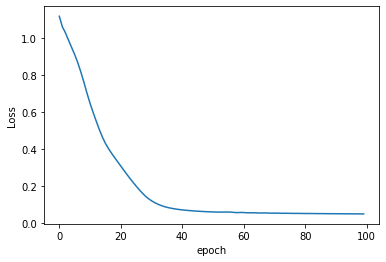

In [ ]:
plt.plot(range(epochs), [ float(l) for l in losses])
plt.ylabel('Loss')
plt.xlabel('epoch');

### Validating and testing the model

In [ ]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())

preds array will acummulate predictions and it is convenient to make a Pandas DataFrame with the following 3 attributes:
* Y: actual value
* YHat   : predicted value
* Correct: 1 if Y and YHat are equal, 0 otherwise. 

In [ ]:
df = pd.DataFrame({'Y': y_test, 'YHat': preds})
df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]
df

,Y,YHat,Correct
0,0,0,1
1,1,1,1
2,0,0,1
3,1,1,1
4,2,2,1
5,0,0,1
6,1,1,1
7,2,2,1
8,2,2,1
9,0,0,1


In [ ]:
df['Correct'].sum() / len(df)

0.9333333333333333

 We can see that our model made just 1 wrong prediction (row index 27). As a result has 96.6 accuracy. 

### Applying the model to classify new, unseen data

In [ ]:
unknown_iris = torch.tensor([4.0,3.3,1.7,0.5])

We may check this new iris in yellow to see where it falls in relation to the others:

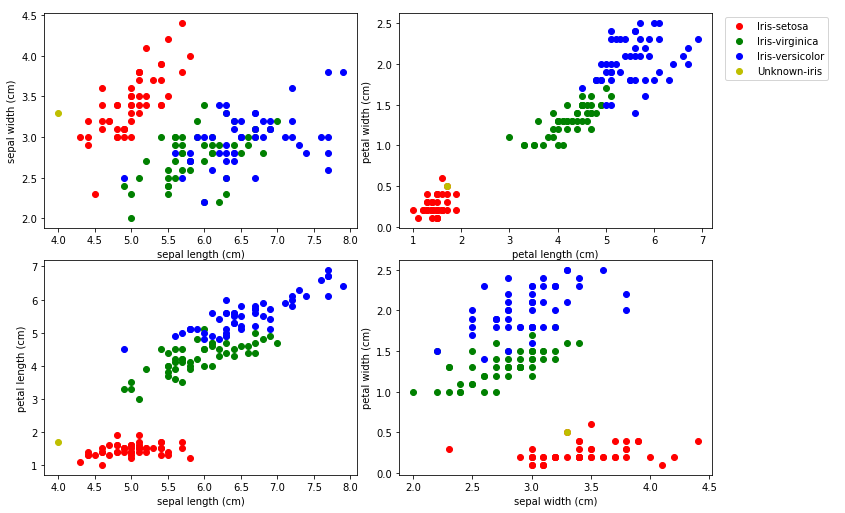

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['r', 'g', 'b']
labels = ['Iris-setosa','Iris-virginica','Iris-versicolor','Unknown-iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = dataset.columns[plots[i][0]]
        y = dataset.columns[plots[i][1]]
        ax.scatter(dataset[dataset["species"]==j][x], dataset[dataset["species"]==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)
        
    # Add a plot for our mystery iris:
    ax.scatter(unknown_iris[plots[i][0]],unknown_iris[plots[i][1]], color='y')
    
fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

We see that this unknown-iris (yellow point) falls into Iris-setosa group. We can verify this by using our model: 

In [ ]:
with torch.no_grad():
    print(model(unknown_iris))
    print()
    print(labels[model(unknown_iris).argmax()])

tensor([ 13.7940,   7.9975, -21.0971])

Iris-setosa


### References
* https://pytorch.org/docs/stable/index.html
* https://www.udemy.com/course/pytorch-for-deep-learning-with-python-bootcamp/
* https://towardsdatascience.com/your-first-neural-network-in-pytorch-725631ae0fc


## Conclusion and suggestions

A type of flower can be predicted according to its properties, a linear model of a neural network can do that.  
To make the model more accurate it is possible to add additional parameters to the classification and use a larger sample size.